# TP 1 - Convolution et Transformée de Fourier
## 1.2 Réaliser une convolution et écouter un écho
### 1.2.3 Valeur en un point

Il y a des problèmes de calcul aux bords du domaine car certains indices peuvent être négatifs. Il faut remédier à ce problème en modifiant le vecteur des indices. En testant notre fonction avec quelques valeurs pré-calculées, on confirme le bon foncitonnement de notre fonction.

In [1]:

import numpy as np

def valconv(h,u,n):
    a=len(h) # pour un tableau numpy len(v)==v.shape[0]
    b=len(u)
    u=u.reshape(-1) #s'assurer que u et v son de la meme forme
    h=h.reshape(-1)
    if n == 0:
        return h[0]*u[0]
    idx = np.arange(max(0,n-b+1), min(a-1, n) + 1)
    return (h[idx]*u[n-idx]).sum()

print(valconv(np.ones(3),np.ones(2),0))
print(valconv(np.ones(3),np.ones(2),2))


1.0
2.0


On étend ensuite notre fonction au calcul complet de la convolution. On compare les résultats à ceux obtenus par la fonction numpy pour vérifier son bon fonctionnement.

In [2]:

def full_conv(h, u):
    a=len(h) # pour un tableau numpy len(v)==v.shape[0]
    b=len(u)
    out = np.zeros((a+b-1))
    u=u.reshape(-1) #s'assurer que u et v son de la meme forme
    h=h.reshape(-1)
    out[0] = h[0]*u[0]
    for n in range(1, a+b-1):
        idx = np.arange(max(0,n-b+1), min(a-1, n) + 1)
        out[n] = (h[idx]*u[n-idx]).sum()
    return out

print(full_conv(np.ones(5),np.ones(7)))
print(np.convolve(np.ones(5),np.ones(7)))


[1. 2. 3. 4. 5. 5. 5. 4. 3. 2. 1.]
[1. 2. 3. 4. 5. 5. 5. 4. 3. 2. 1.]


### 1.2.5 Ecoute d'un écho
Dans cette partie, on s'intéresse au rôle de la convolution dans la synthèse d'un écho. On commence par écouter l'enregistrement de la note de piano. Le fait de lire l'enregistrement avec une fréquence d'échantillonnage de $\frac{F_e}{2}$ diminue la fréquence de la note entendue par 2 et double le temps de lecture. On génère le vecteur $\bf h$ qui est composé de 2 Dirac, que l'on convolue ensuite à notre enregistrement.

In [3]:

import soundfile as sf
import matplotlib.pyplot as plt
import sounddevice as sd
from time import time

[x,Fe]=sf.read('piano.wav')
def echo(x, Fe, t1):
    n1 = round(t1*Fe)
    h = np.zeros((n1+1))
    h[0]=1
    h[n1]=0.8
    return full_conv(h, x)

def echo_scipy(x, Fe, t1):
    n1 = round(t1*Fe)
    h = np.zeros((n1+1))
    h[0]=1
    h[n1]=0.8
    return np.convolve(h, x)

En mesurant les temps de calcul, on se rend compte que la fonction de numpy (l'usage de cette fonction est conseillé plutôt que la fonction de scipy. L'implémentation est la même) est bien plus rapide que notre implémentation. 
La fonction de numpy utilise la propriété du produit de convolution qui devient un produit dans l'espace de Fourier. Dans cet espace on peut bénéficier de la FFT et donc réduire le temps de calcul.

In [4]:
t1 = 0.1
start = time()
y = echo(x, Fe, t1)
stop = time()
print(f'Temps de calcul fonction basique : {stop-start}')
sf.write(f'results\\echo{t1}.flac', y, Fe)

start = time()
y = echo_scipy(x, Fe, t1)
stop = time()
print(f'Temps de calcul func scipy : {stop-start}')

Temps de calcul fonction basique : 6.903791189193726
Temps de calcul func scipy : 0.09050846099853516


Avec $t_1=0.1$, on a l'impression que la note a été jouée deux fois. La vitesse du son dans l'air à 20°C est d'environ 340 $m.s^{-1}$. Donc 0.1 $s$ représente 34 $m$ et 0.01 $s$ représente 3.4 $m$.

## 1.3 Filtre Rejecteur
Dans cette partie on s'intéresse au rejet d'une perturbation de fréquence connue. La fréquence est de $f_0 = 1261 Hz$, soit une fréquence réduite $\nu = \frac{f_0}{F_e} = 0.0263$.

La fonction de transfert du filtre rejette1 est $H_1 = 1 - z_0z^{-1}$. Ce filtre réduit beaucoup le volume général de l'enregistrement et on ne distingue presque pas l'atténuation.

La fonction de transfert du filtre rejette2 est $H_2 = \frac{1 - z_0z^{-1}}{1 - \rho z_0z^{-1}}$. Ce filtre rejette de façon plus efficace la perturbation.

<img src="cercle.jpg" alt="Placement des pôles" /> - La photo est dans le dossier.

Le paramètre $\rho$ doit toujours être inférieur à 1 pour que les pôles soient dans le cercle unité. Cela assure un filtre causal stable.

Prendre un rho très proche de 1 va faire un filtre plus sélectif, mais il faut avoir une information très précise sur la fréquence à rejeter pour ne pas risquer de tomber "à côté" et ne finalement rien atténuer.

In [5]:
from math import pi
import scipy

n=np.arange(len(y)) #le temps discret que dure le signal y
f0=1261 #fréquence en Hertz
#La fréquence réduite est f0/Fe = 0.0263
parasite = 0.1*np.cos(2*pi*f0/Fe*n)
yb=y + parasite #on ajoute une onde parasite
sf.write(f'results\\echo_pollution{f0}.flac', yb, Fe)

def rejette1(entree,f0,Fs):
#valeur recommandée pour rho: au moins 0.9 et jamais plus de 1
    lfilter=scipy.signal.lfilter
    z0=np.exp(2*1j*pi*f0/Fs) # position sur le cercle unite de la fréquence à éliminer
    
    sortie=lfilter([1 ,-z0],1,entree)
    
    sortie=lfilter([1, -np.conj(z0)],1,sortie) #Le signal est reel, il faut donc éliminer -f0 aussi!
    
    
    sortie=np.real(sortie);# En raison d'erreurs d'arrondi il peut subsister une partie imaginaire
    return sortie
    
def rejette2(entree,f0,Fs,rho):
#valeur recommandée pour rho: au moins 0.9 et jamais plus de 1
    lfilter=scipy.signal.lfilter
    z0=np.exp(2*1j*pi*f0/Fs) # position sur le cercle unite de la fréquence à éliminer
    
    sortie=lfilter([1 ,-z0],[1 ,-rho*z0],entree)
    
    sortie=lfilter([1, -np.conj(z0)],[1 ,-rho*np.conj(z0)],sortie) #Le signal est reel, il faut donc éliminer -f0 aussi!

    sortie=np.real(sortie)# En raison d'erreurs d'arrondi il peut subsister une partie imaginaire
    return sortie

premier_filtre = rejette1(yb, f0, Fe)
second_filtre = rejette2(yb, f0+6, Fe, 0.90)

sf.write(f'results\\rejette1_{f0}.flac', premier_filtre, Fe) # rejette1 atténue beaucoup trop le signal que l'on doit garder
sf.write(f'results\\rejette2_{f0}.flac', second_filtre, Fe)

## 2 Transformation de Fourier et échantillonnage 
### 2.2 Transformation de fourier

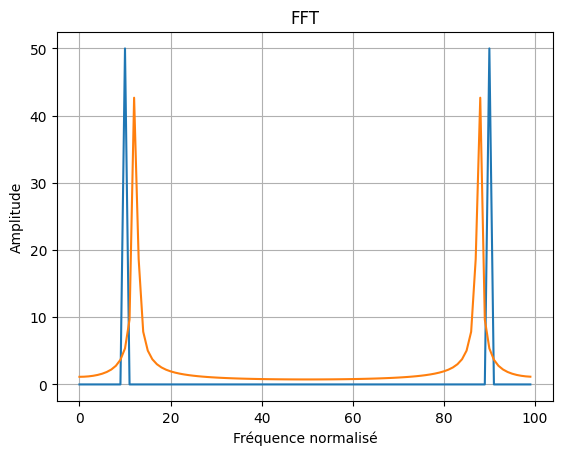

In [6]:
import matplotlib.pyplot as plt

size = np.arange(100)

s1 = np.sin(2*np.pi*0.1*size)
s2 = np.sin(2*np.pi*0.123*size)

fig, ax = plt.subplots()
ax.plot(abs(np.fft.fft(s1)))
ax.plot(abs(np.fft.fft(s2)))

ax.set(xlabel='Fréquence normalisé', ylabel='Amplitude',
       title='FFT')
ax.grid()

plt.show()

On remarque une différence au niveau de la formes des crêtes dessinés sur le graphique. L'amplitude est plus importante dans le cas du sinus de fréquance normalisée 0.1 par rapport au sinus 0.123. La crête est moins importante mais plus large. Cela est dû au fait que l'échantillonnage du spectre de notre signal, que l'on peut considérer comme un signal tronqué par une porte, ne se fait pas sur le pas de grille. En effet, le spectre continu d'un sinus pur serait un sinus cardinal de l'ingénieur. Or on doit l'échantillonner sur 100 points, et le fait que $0.123 = \frac{12,3}{100}$ induit un décalage : au lieu d'échantillonner le sinus cardinal de l'ingénieur au maximum du lobe principal, puis aux endroits ou les lobes secondaires s'annulent (comme dans le cas précédent), il y a ici des lobes secondaires qui ont été gardé du fait que 0.123 ne soit pas sur la grille.

## 2.3 Fréquence réduite et Hz

In [7]:
nu = 0.01
n = np.arange(10000)
x = np.sin(2*pi*nu*n)

Fe = 44100

sf.write(f'results\\frequence_reduite_{Fe}.flac', x, Fe)
sf.write(f'results\\frequence_reduite_{Fe/2}.flac', x, int(Fe/2))

Dans le cas $F_e = 44100 Hz$, on le son produit a une fréquence réelle de 441 $Hz$, et de seulement 220.5 $Hz$ dans le second cas.